# Before use: please run following cells once with connection to gas bottle

In [1]:
import RPi.GPIO as GPIO
import time

import os
import sounddevice as sd
from scipy.io.wavfile import write, read
import RPi.GPIO as GPIO

import matplotlib.pyplot as plt
import numpy as np
import scipy.fft
from scipy.signal import find_peaks, peak_widths, savgol_filter
import statistics
import math


from IPython.display import clear_output
import time
import pickle

GPIO.setmode(GPIO.BCM)

# Raspberry Pi Pin-Belegung für TB6600 Treiber
DIR = 13
PUL = 19
ENA = 26

DIR_Left = GPIO.HIGH
DIR_Right = GPIO.LOW

ENA_Locked = GPIO.LOW
ENA_Released = GPIO.HIGH

GPIO.setwarnings(False)
GPIO.setup(DIR, GPIO.OUT)
GPIO.setup(PUL, GPIO.OUT)
GPIO.setup(ENA, GPIO.OUT)

GPIO.setmode(GPIO.BCM)
GPIO.setup(21, GPIO.OUT)
plt.rc('font', family='serif')

In [3]:
# opens valve to fill gas system
GPIO.output(21, GPIO.HIGH)
time.sleep(.5)
GPIO.output(21, GPIO.LOW)

## Different movements

In [7]:
def move_to_wire(steps,position,t=0.001):
    '''
    moves sled to set position (over/near wire)
    - steps (int):    steps movement has to do
    - position (int): actual position (in steps), from where the movement starts
    - t (int):        step-time for stepper-motor, sets speed
    
    returns: position (in steps) after movement
    '''
    steps=int(steps)
    # Motor aktivieren und halten
    GPIO.output(ENA, ENA_Locked)

    # Richtung abhängig von positivem oder negativem Wert
    if (steps < 0):
        GPIO.output(DIR, DIR_Left)
        steps=steps*-1
        direction=-1
    else:
        GPIO.output(DIR, DIR_Right)
        direction=1

    if steps>0:   

        for i in range(steps):
            GPIO.output(PUL, GPIO.HIGH)
            time.sleep(t)

            GPIO.output(PUL, GPIO.LOW)
            time.sleep(t)
    
    position +=direction*steps
    return position

def auf_Anfang(position,t=0.001):
    '''
    moves sled to the starting position. 
    - position (int): actual position (in steps), from where the movement starts
    - t (int):        step-time for stepper-motor, sets speed
    
    if starting position is not reeached: error message: help me please
    '''
    steps=int(-1*position)
    # Motor aktivieren und halten
    GPIO.output(ENA, ENA_Locked)

    # Richtung abhängig von positivem oder negativem Wert
    if (steps < 0):
        GPIO.output(DIR, DIR_Left)
        steps=steps*-1
        direction=-1
    else:
        GPIO.output(DIR, DIR_Right)
        direction=1

    if steps>0:   

        for i in range(steps):
            GPIO.output(PUL, GPIO.HIGH)
            time.sleep(t)

            GPIO.output(PUL, GPIO.LOW)
            time.sleep(t)
    
    position += direction*steps
    if position==0:
        print('ready again')
    else:
        print('help me please')
    GPIO.output(ENA, ENA_Released) 

def find_wire(position,steps=60, k=0.4, corr_steps=0, tm=0.1,fs=48000, plot=False):
    '''
    searches for wire and positions sled over it:
    sled moves the complete distance over the wire recording a signal: peak in recording
    moves back until a set factor k of the peak can be measured. 
    - position (int):   actual position (in steps), from where the movement starts
    - steps (int):      search distance (in steps) in which the wire is searched
    - k (int):          scale factor to refind peak
    - corr_steps (int): correcting steps (moving backwords), only if sled stops too late systematicly
    - tm (int):         step-time for stepper-motor, sets speed
    - fs (int):         sample of the soundcard rate for the recording
    
    returns: position (in steps) after movement
    '''
    pos=position
    
    steps=int(steps)
    # activate motor and hold
    GPIO.output(ENA, ENA_Locked)

    # set direction dependant on pos. od neg. steps, pos is to the right
    if (steps < 0):
        GPIO.output(DIR, DIR_Left)
        steps=steps*-1
        direction=-1
    else:
        GPIO.output(DIR, DIR_Right)
        direction=1

    signal=[]

    # moving over wire recording signal
    for i in range(steps):
        GPIO.output(PUL, GPIO.HIGH)
        time.sleep(tm)
    
        signal.append(sd.rec(1, samplerate=fs, channels=1))
    
        GPIO.output(PUL, GPIO.LOW)
        time.sleep(tm)
    
        signal.append(sd.rec(1, samplerate=fs, channels=1))
        
    position += direction*steps
    
    # looking for peak
    signal=np.array(signal)
    signal=signal[:,0]

    x=np.where(signal==max(signal))[0]
    y=signal[x]*k
    
    if plot==True:
        x=np.arange(0,len(signal))
        plt.plot(x,signal)
    plt.show()
    
    # turn around direction
    if direction>0:
        GPIO.output(DIR, DIR_Left)
        direction=-1
    else:
        GPIO.output(DIR, DIR_Right)
        direction=1

    #start value for while 
    signal2=abs(sd.rec(5, samplerate=fs, channels=1)[2])
    
    while signal2<y and pos<=position:
        GPIO.output(PUL, GPIO.HIGH)
        time.sleep(tm)
    
        GPIO.output(PUL, GPIO.LOW)
        time.sleep(tm)
   
        signal2=abs(sd.rec(5, samplerate=fs, channels=1)[2])
        position += direction
    if pos==position:
        print('hoppla')
    
    # correction steps backwords only if sled stopped too late over wire
    if direction>0:
        GPIO.output(DIR, DIR_Left)
        direction=-1
    else:
        GPIO.output(DIR, DIR_Right)
        direction=1

    for i in range(0,corr_steps):
        GPIO.output(PUL, GPIO.HIGH)
        time.sleep(tm)
    
        GPIO.output(PUL, GPIO.LOW)
        time.sleep(tm)
        position += direction
    return position


## Tension measurement software

In [8]:
def new_record(seconds=3, signalname='signal', fs=48000, plot=False):
    '''
    Records audio signal with sd.rec() from module sounddevice for set amount of seconds and with set 
    samplerate.
    The signal is recorded for the set time plus 0.2 seconds. Returned is only the signal measured 
    from 0.2 seconds onwards.
    
    Args:
        seconds (float): number of seconds for which signal is recorded
        signalname(str): plotlabel of signal if plot is shown
        fs (int):        samplerate (samples taken per second)
        plot (bool):     if True, recorded signal is plotted over time
        
    '''
    
    t = np.arange(0, seconds, 1/fs)
    seconds += 0.2
    
    #start recording    
    recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    print("Starting recording")
    sd.wait()  # Wait until recording is finished
    print("finished")
    
    #turn signal into list of data
    l = [[i for i in elem] for elem in recording]
    ll = []
    for x in l:
        ll+=x
    
    # plot signal
    if plot == True:
        fig_ratio=9/16
        fig_size_x= 6.8#3.07 #inch

        plt.figure(figsize=(fig_size_x,fig_size_x*fig_ratio),dpi=150)
        plt.plot(t, ll[int(0.2*fs):], label=signalname)

        plt.xlabel('t [s]',fontsize=10)
        plt.ylabel('amplitude [a.u.]',fontsize=10)
        plt.legend(loc='upper right',fontsize=10)
    
    return np.array(ll[int(0.2*fs):])

def findPeaks(data, noise, fs=48000, peaks=5, name='data', plot=False, _xrange=None, expect_low=0, expect_high=10000):
    '''
    Turns signal over time into frequency spectrum and subtracts the background. Plots the spectrum of 
    signal and noise in one plot and the corrected spectrum in another. Then finds the normal mode 
    of the corrected spectrum and returns both the normal mode and the frequency resolution of the spectrum.
    
    Args:
        data (array):      signal over time of the oscillating wire
        noise (array):     signal over time of the background (wire without orcillation)
        fs (int):          sample rate that was used to record data and noise
        peaks (int):       number of highest frequency peaks taken into account for the identification of the 
                           normal mode
        name (str):        plotlabel of the data signal shown in plot
        plot (bool):       if True, plots of frequency spectrums are shown
        _xrange (list):    lower and upper limit for x-axis for plot
        _yrange (list):    lower and upper limit for y-axis fot plot
        expect_low (int):  lower limit for peak search to reduce false peaks from unexpected frequencies
        expect_high (int): upper limit for peak search to reduce false peaks from unexpected frequencies
        
    Returns:
        normalMode (float): identified normal mode of corrected spectrum
        Δf (float):         frequncy resolution (bin width) of frequency spectrum
        
    '''
    
    N = len(data)  # = t * fs
    T = 1 / fs
    Δf = fs/(N) # [Hz]
    expect_low=int(expect_low/Δf)
    expect_high=int(expect_high/Δf)
    
    # Fourier transform of data and noise
    fft_data = scipy.fft.fft(data)
    fft_background = scipy.fft.fft(noise)
    max_freq = int( fs / 2 ) # Nyquist theorem: only frequencies up to 0.5*fs
    
    
    fft_abs = 2/N * abs(fft_data[:int(N/2)])
    fft_noise = 2/N * abs(fft_background[:int(N/2)])
    fft_corr = list(fft_abs - fft_noise)
    fft_freq = np.arange(0, max_freq, Δf)
    
        
    print(f'Frequency resolution is {Δf = } Hz')
        
    
    ###########################################################################
    # search frequency spectrum for amount of peaks given by parameter 'peaks'
    ###########################################################################
    
    peak_count = 0
    f_list = list()
    a_list = list()
    fft_orig = fft_corr.copy() # save copy of original corrected spectrum
    while peak_count < peaks: 
        
        # identify max peak and its width and collect frequency and amplitude in f_list and a_list
        peak_idx = np.where(fft_corr == max(fft_corr[expect_low:expect_high]))[0][0]
        width = int(peak_widths(fft_corr, [peak_idx], 0.9)[0][0])+1
        max_f = fft_freq[peak_idx]
        max_a = fft_corr[peak_idx]
        f_list.append(max_f)
        a_list.append(max_a)
        
        
        # Savitzky-Golay filter to smooth peak data
        window = 4*(2*int(width/2))+1
        poly = 1
        n = 0
        success = False
        while success == False and n < 10:
            try:
                fitted_peak = savgol_filter(fft_corr, window, poly, mode='constant', cval=0)
                success = True
            except ValueError:
                window += 2
                print('ValueError, trying to expand window:')
                print(f'{window=}, {poly=}')
                n += 1
        
        # max peak and width of filtered data
        try:
            if peak_idx <= width/2:
                fitted_peak_idx = np.where(fitted_peak == max(fitted_peak[0:peak_idx+2*width+1]))[0][0]
            else:    
                fitted_peak_idx = np.where(fitted_peak == max(fitted_peak[peak_idx-1-width:peak_idx+1+width]))[0][0]
        except ValueError: # break if no further peaks could be found because of ugly spectrum
            break
                
        fitted_width = int(peak_widths(fitted_peak, [fitted_peak_idx], 0.8)[0][0]) + 2
        if fitted_width <25/Δf:      # set minimum peak width to x Hz = x/Δf
            fitted_width = int(25/Δf)
        
        # list containing fitted peak
        fitted_peak_list = fft_corr[peak_idx-int(fitted_width/2):peak_idx+int(fitted_width/2)+1]
        fitted_peak_length = len(fitted_peak_list)

        # eliminate peak from fft_corr spectrum
        fft_corr = fft_corr[:peak_idx-int(fitted_width/2)] + fitted_peak_length * [0] + fft_corr[peak_idx+int(fitted_width/2)+1:]
             
        peak_count += 1
        # repeat process until all peaks are found and eliminated from fft_corr
        
    peaks = peak_count # number of found peaks
    print(f_list)
    
    ##############################################################################
    # Find normal mode of frequency peaks
    ##############################################################################
    
    # sort f_list and a_list by frequency
    f_list_sIdx = np.argsort(f_list)
    f_list = [f_list[i] for i in f_list_sIdx]
    a_list = [a_list[i] for i in f_list_sIdx]
    
    foundPeaks = f_list.copy()  # copy of list with frequencies of all identified peaks
    afoundPeaks = a_list.copy() # copy of list with amplitudes of all identified peaks
    
    # calculate distances between peaks
    l1 = f_list.copy()
    a1 = a_list.copy()
    l1.append(0)
    a1.append(0)
    l2 = f_list.copy()
    a2 = a_list.copy()
    l2.insert(0, 0)
    a2.insert(0, 0)
    
    freqDistances = [l1[i]-l2[i] for i in range(len(l1)-1)]
    aDistances = [(l1[i]-l2[i])/2 for i in range(len(l1)-1)]
    fD_sIdx = np.argsort(freqDistances)
    freqDistances = [freqDistances[i] for i in fD_sIdx]
    aDistances = [aDistances[i] for i in fD_sIdx]
    

    # calculate mean of freqDistances that are within 5Hz of each other
    meanlist  = []
    meanalist = []
    while freqDistances != []:
        refFreq = min(freqDistances)
        freqDistances.remove(refFreq)
        meana = aDistances.pop(0)
        mean = refFreq
        count = 1
        freqDistances_c = freqDistances.copy()
        for d in freqDistances_c:
            if d <= refFreq+5:
                mean += d
                meana += aDistances[freqDistances.index(d)]
                count += 1
                aDistances.pop(freqDistances.index(d))
                freqDistances.remove(d)
        for f in f_list:
            if f <= refFreq+5:
                mean += f
                meana += a_list[f_list.index(f)]
                count += 1
                a_list.pop(f_list.index(f))
                f_list.remove(f)
        meanlist.append(mean/count)
        meanalist.append(meana/count)

    # make list of possible normal modes
    possNormalModes = f_list + meanlist
    aNormalModes = a_list + meanalist
    pNM_sIdx = np.argsort(possNormalModes)
    possNormalModes = [possNormalModes[i] for i in pNM_sIdx]
    aNormalModes = [aNormalModes[i] for i in pNM_sIdx]
    
    if possNormalModes[0] < 0.1:   # because code doesn't work when 0 is contained in possNormalModes
        possNormalModes.pop(0)
        aNormalModes.pop(0)
    
    # starting from the lowest frequency in possNormalModes, check which of the other 
    # frequencies are multiples of the first (and therefore harmonics) and put them all 
    # in list newFreqGroup. Then collect newFreqGroup lists in harmonics list.
    possNormalModes_c = possNormalModes.copy()
    harmonics = []
    totalAmp = 0
    
    #print(possNormalModes)

    while possNormalModes != []:
        newFreq = min(possNormalModes)
        newFreqGroup = []
        t_max = math.floor(max(possNormalModes)/newFreq)
        totalAmp = 0
        for f in possNormalModes_c:
            for t in np.arange(1, t_max+1, 1):
                if int(f)-2 <= int(t*newFreq) <= int(f)+2:
                    try:
                        possNormalModes.remove(f)
                        newFreqGroup.append(f)
                        totalAmp += aNormalModes[possNormalModes_c.index(f)]
                        break
                    except ValueError:
                        break
                    
        newFreqGroup.insert(0, totalAmp*1e-6)
        harmonics.append(newFreqGroup)

    # sort lists in 'harmonics' by how many harmonics were found
    harmonics.sort(key=len)
    
    try:
        if len(harmonics[-1]) == len(harmonics[-2]):
            # sort by total Amplitude    
            harmonics.sort(key = lambda harmonics: harmonics[0])
    except IndexError:
        print('All peaks belong to same normal Mode')

    normalMode = harmonics[-1][1]
    n_harmonics = len(harmonics[-1])

    ############################################################################
    # Plot spectrum and peaks and normal mode
    ############################################################################
    
    if plot == True:   
        fig, axs = plt.subplots(1, 2, figsize=(11, 3.84))

        ax = axs[0]
        ax.axvline(normalMode, color='r', linestyle='--', label=f'{normalMode}')
        ax.plot(fft_freq, fft_abs, label=name)
        ax.plot(fft_freq, fft_noise, label='noise')

        if _xrange is not None:
            ax.set_xlim(_xrange[0],_xrange[1])
        else:
            #ax.set_xlim(min_freq-0.1*freq_span, max_freq+0.1*freq_span)
            ax.set_xlim(0, 5000)
        ax.set_xlabel('frequency [Hz]',fontsize=10)
        ax.set_ylabel('amplitude a.u.',fontsize=10)
        ax.legend()

        ax = axs[1]
        ax.plot(fft_freq, fft_orig, label='peaks')
        #ax.plot(fft_freq, fft_corr, label='corrected spectrum')
        ax.axvline(normalMode, color='r', linestyle='--', label='normal Mode')

        if peaks == 1:
            min_freq = foundPeaks[0] - 10
            max_freq = foundPeaks[0] + 10
        else:
            min_freq = min(list(foundPeaks)+[normalMode])
            max_freq = max(list(foundPeaks)+[normalMode])

        freq_span = max_freq - min_freq

        for f, a in zip(foundPeaks, afoundPeaks):
            if f >= 0.5*freq_span + min_freq:
                plt.annotate(f'{int(f)}Hz', (f, a), (f-0.15*freq_span, a), xycoords='data', 
                             arrowprops=dict(arrowstyle="->"), ha='center', va='center')
            else:
                plt.annotate(f'{int(f)}Hz', (f, a), (f+0.15*freq_span, a), xycoords='data',
                             arrowprops=dict(arrowstyle="->"), ha='center', va='center')


        
        ax.set_xlim(min_freq-0.1*freq_span, max_freq+0.1*freq_span)
        #ax.set_xlim(0,4000)
        ax.set_xlabel('frequency [Hz]',fontsize=10)
        ax.set_ylabel('amplitude a.u.',fontsize=10)
        ax.legend(fontsize=10)
        plt.show()
    
    print('possible normal modes:', possNormalModes_c)    
    print('Maxima at:', foundPeaks, 'Hz')
    print(f'{normalMode=}')
    
    return normalMode, Δf

# Measurement of several single wires

In [19]:
def measureWire(picklename, senconds=int(3)):
    '''
    laser, nozzle and diode move to wire, position is entered for each wire
    Record background and wire oscillation for wires of different tension, which are set with the wire clamp.
    After every measurement, the recorded spectrum is shown and three different chioces can be made:
        'c' (continue): the last measurement is saved and a new one will be taken
        's' (stop):     the last measurement is saved and the measurement series finished
        'r' (repeat):   the last measurement is not saved and a new measurement will be taken
    When the measurement series is finished, the recorded signals as well as the wire parameters and steps of 
    the wire clamp are saved as a pickle file.
    
    Args:
        picklename (str): name of pickle file in which measurement series is saved
        s (float):        amount of time for which signals (both background and oscillation) are recorded
        
    The measurement series is saved as a pickle file containing the list [params, U, data] where
        params (list): list containing initial length l of the wire, its diameter d and the weight m_0 with
                       which it was initially set up in the wire clamp, all in SI units
        U (list):      list containing the position of the threaded rod of the wire clamp, given in fractions 
                       of one full turn. One full turn elongates the wire by 1mm, therefore U also gives the 
                       elongation of the wire in mm.
        data (list):   list containing lists [signal, noise] for every set value in U. signal is the measured
                       signal while the wire was oscillating whereas noise is the signal measured while
                       the wire was still.       
    
    '''
    
    U = []
    s = []
    data = []
    toDo = 'c'
    params = []
    F=[]
    dF=[]
    
    l = input('Wire length in millimeters:') #[mm]
    d = input('Wire diameter in meters:') #[m]
    m_0 = input('additional information') #[kg]
    
    params.append(l)
    params.append(d)
    params.append(m_0)
    
    while toDo == 'c':
        position=0
        newU = float(input('Type in current steps on rod turn '))/32 #one full turn of rod consists of 32 steps
        steps=float(input('approx. Postion of wire in mm'))*3.35
        #move to wire
        position=move_to_wire((steps-20),position)
        position=find_wire(position, steps=40, k=0.3, corr_steps=1, plot=False)
        
        #measure
        noise = new_record(seconds=seconds)
        GPIO.output(21, GPIO.HIGH)
        time.sleep(.1)
        GPIO.output(21, GPIO.LOW)
        time.sleep(.1)
        signal = new_record(seconds=seconds)
        try:
            f,df=findPeaks(signal, noise, peaks=5, plot=True, expect_low=50)
        except ValueError:
            print('ValueError')
            
        #move on starting position
        auf_Anfang(position)
        
        toDo = input('type c for continue, s for stop or r for repeat')
        if toDo == 'c':
            clear_output()
            print(f'Saving the last recording at wire number{newU}')
            U.append(newU)
            s.append(steps/3.35)
            data.append([signal, noise])
            F.append(f)
            dF.append(df)
            with open(picklename, 'wb') as f:
                pickle.dump([params, U, s,  F, dF, data] , f)
            
        elif toDo == 'r':
            clear_output()
            print(f'Not saving the last recording wire number {newU}')
            toDo = 'c'
        elif toDo == 's':
            clear_output()
            F.append(f)
            dF.append(df)
            U.append(newU)
            s.append(steps/3.35)
            data.append([signal, noise])
            print(f'Saving the last recording at wire number {newU} and stopping measurement')
     # save measurement series with pickle
    with open(picklename, 'wb') as f:
        pickle.dump([params, U, s, F, dF, data] , f) 

In [20]:
measureWire('test 1')

Wire length in millimeters:1
Wire diameter in meters:0.22
additional information
Type in current steps on rod turn 0
approx. Postion of wire in mm875


NameError: name 'seconds' is not defined

# Measurement of a single wire

approx. Postion of wire in mm875


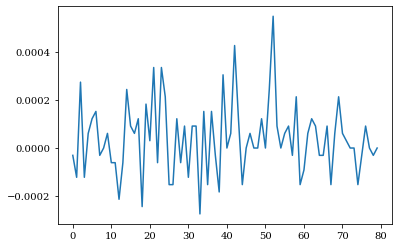

Starting recording
finished
Starting recording
finished
Frequency resolution is Δf = 0.3333333333333333 Hz
[53.666666666666664, 124.33333333333333, 86.0, 154.66666666666666, 202.33333333333331]


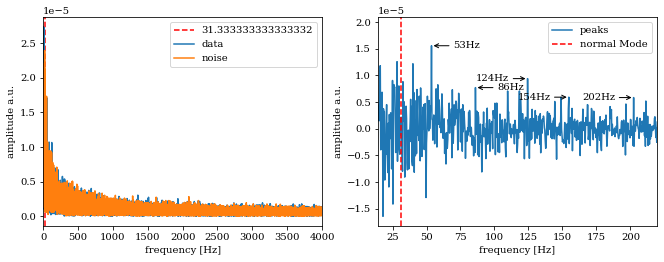

possible normal modes: [31.333333333333332, 38.33333333333333, 47.66666666666666, 53.666666666666664, 86.0, 124.33333333333333, 154.66666666666666, 202.33333333333331]
Maxima at: [53.666666666666664, 86.0, 124.33333333333333, 154.66666666666666, 202.33333333333331] Hz
normalMode=31.333333333333332
ready again


In [25]:
position=0
steps=float(input('approx. Postion of wire in mm'))*3.35 #eigentlich 3,57
#search in approx. 1cm 
position=move_to_wire((steps-20),position)
position=find_wire(position, steps=40, k=0.3, corr_steps=1, plot=True)

background=new_record(seconds=3, plot=False)

GPIO.output(21, GPIO.HIGH)
time.sleep(.08)
GPIO.output(21, GPIO.LOW)
time.sleep(.2)
recording=new_record(seconds=3, plot=False)

findPeaks(recording, background, peaks=5, plot=True, _xrange=[0,4000],expect_low=20)

auf_Anfang(position)

In [4]:
# Release the stepper motor to move sled by hand or if not use for a longer time
GPIO.output(ENA, ENA_Released) 